In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

# получение данных из CSV
requests = pd.read_csv('data/requests_every_hour.csv',header=0)

requests.head()

,Requests
0,100
1,113
2,162
3,186
4,228


In [ ]:
print(f'Количество строк в исходных данных: {requests.shape[0]}\nКоличество столбцов в исходных данных: {requests.shape[1]}')

Количество строк в исходных данных: 840
Количество столбцов в исходных данных: 1


In [ ]:
print('Пропущенных значений:')
requests.isna().sum()

Пропущенных значений:


Requests    0
dtype: int64

In [ ]:
print('Типы столбцов:')
requests.dtypes

Типы столбцов:


Requests    int64
dtype: object

In [ ]:
print(f'Количество часов данных: {requests.shape[0]}\nКоличество дней данных: {int(requests.shape[0]/24)}\nКоличество недель данных: {int(requests.shape[0]/24/7)}')

Количество часов данных: 840
Количество дней данных: 35
Количество недель данных: 5


В исходных данных содержится один столбец - **Requests**. Он отражает временной ряд почасовой нагрузки на сервис, выраженный в числовом формате int64. Пропусков в исходных данных не имеется, потому очистка данных не требуется. Для решения такого рода задач следует использовать рекуррентную нейронную сеть и оценивать такими метриками, как Mean Absolute Error (MAE), Mean Squared Error (MSE). Для обозначения ожидаемых результатов метрик следует напомнить, за что каждая из них отвечает.

* MAE (Mean Absolute Error, Средняя абсолютная ошибка) - это среднее значение абсолютных отклонений предсказаний модели от истинных значений.

* MSE (Mean Squared Error, Средняя квадратичная ошибка) - это среднее значение квадратов отклонений предсказаний модели от истинных значений. Эта метрика измеряется в квадратных единицах и часто используется для пенализации больших ошибок.

* R2 (R-squared) - это статистическая метрика, которая измеряет прогнозирующую способность модели и показывает, насколько хорошо модель объясняет вариацию в данных.

В целом, все три метрики оценивают качество модели, и чем ниже значения MAE и MSE, тем лучше модель.


Наш набор данных имеет информацию о 840 часах (или 35 днях, или 7 неделях) нагрузки на сервис. Данная информация необходима для начала работы.

Перед работой с исходными данными, их следует нанести на график, чтобы выявить закономерности. Начнем с первого дня, который составляет 24 точки данных. Затем мы делаем тот же шаблон для первых недель, что составляет 168 точек данных. Наконец, мы делаем это для всех пяти недель.

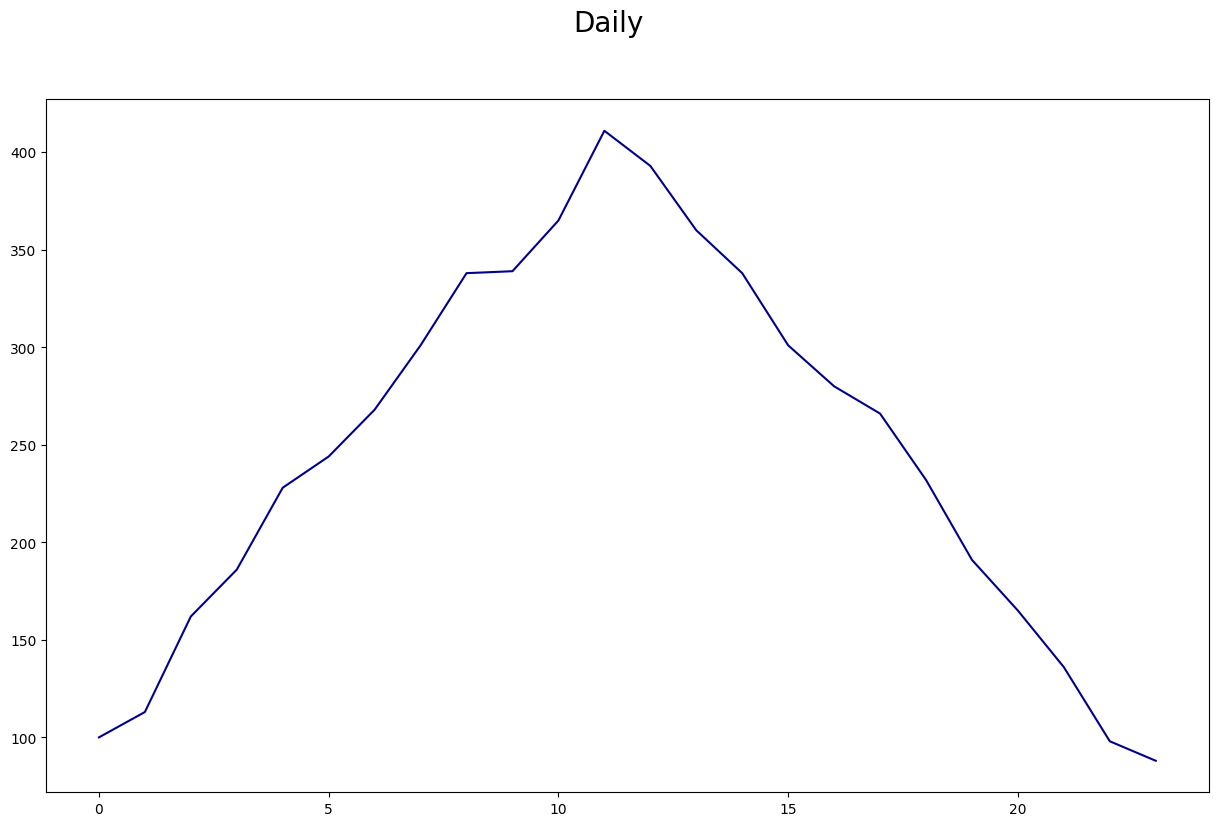

In [ ]:
# график по дням
plt.figure(figsize=(15,9)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24), color='darkblue')
plt.show()

На дневном графике мы видим, что он похож на пирамида с самой высокой нагрузкой в ​​середине дня, а ночью с меньшей нагрузкой.

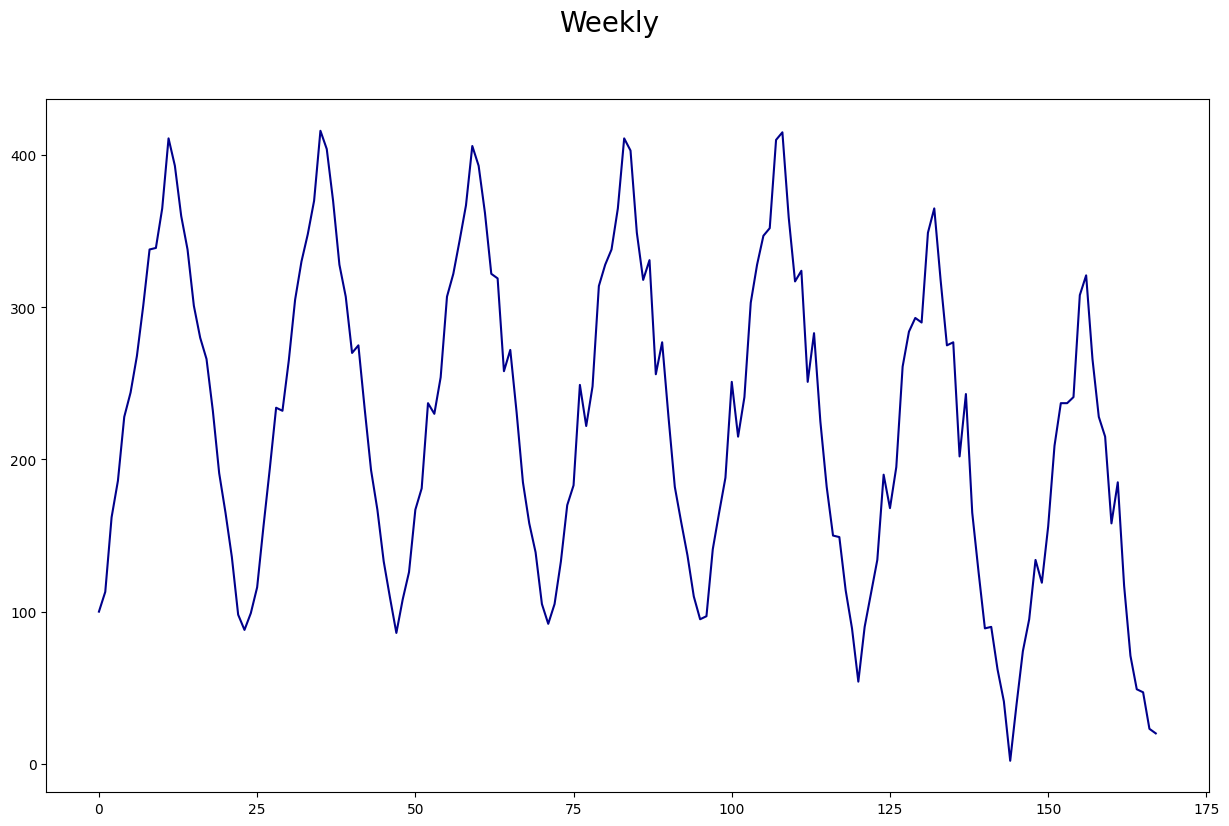

In [ ]:
# график по неделям
plt.figure(figsize=(15,9)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168), color='darkblue')
plt.show()

На недельном графике мы видим, что дневной тренд повторяется каждый день, мы видим семь пирамид. Мы также замечаем, что последние две пирамиды, которые представляют собой субботу и воскресенье, немного ниже.

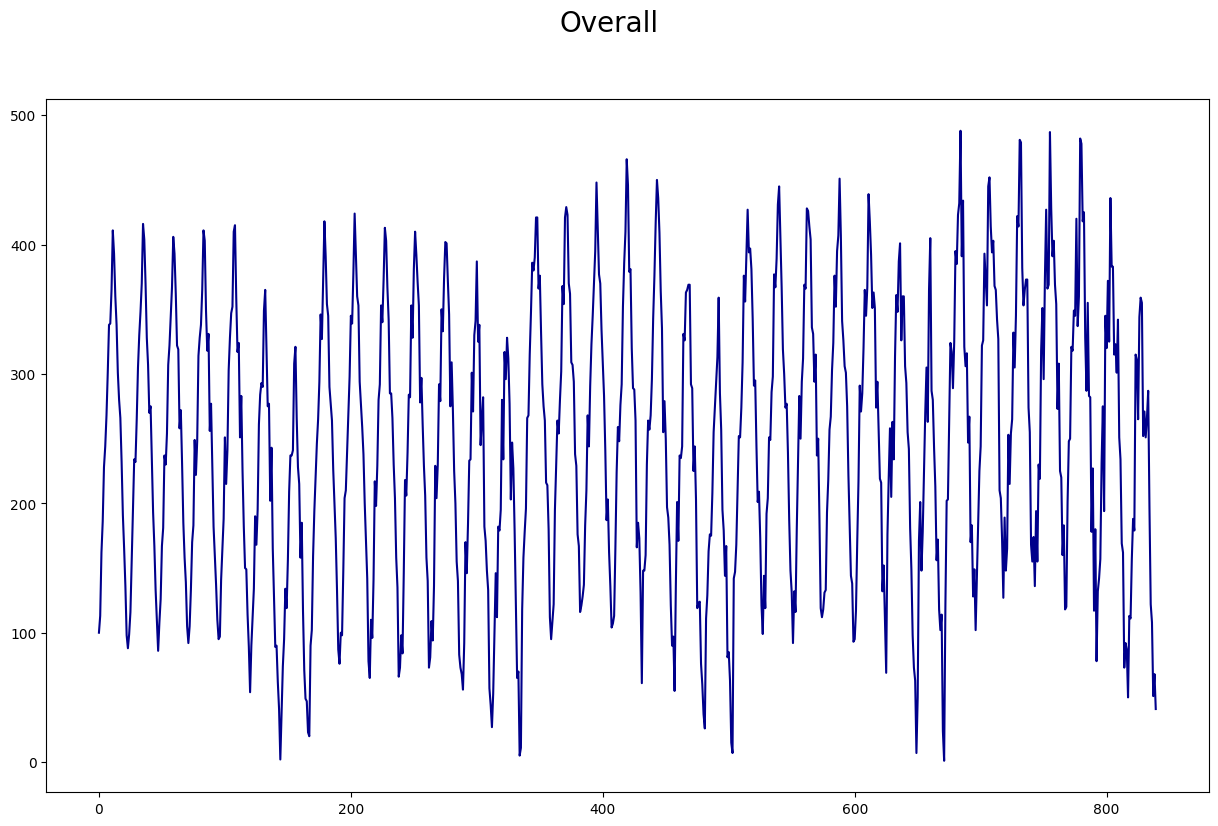

In [ ]:
# график всех данных
plt.figure(figsize=(15,9)).suptitle("Overall", fontsize=20)
plt.plot(requests, color='darkblue')
plt.show()

На графике всех исходных данных мы видим повторяющийся недельный паттерн. Но мы также видим небольшое увеличение общего объема по отношению к прошлой неделе. Это тенденция роста.

Чтобы подготовить данные для глубокого обучения, нам сначала нужно масштабировать данные до стандартного масштаба. Для этой цели мы используем StandardScaler из библиотеки Scikit-learn. Таким образом мы создаём точки данных со средним значением, равным нулю. Затем мы печатаем значения до и после масштабирования.

Далее нам нужно разделить наборы данных для обучения и тестирования. В отличие от других случаев использования машинного обучения, где мы можем случайным образом разделить входной набор на обучение и тестирование, в RNN нам нужно разделить последовательно. Мы устанавливаем данные обучения на первые четыре недели набора данных, а тестирование — на последнюю неделю. Ключевым гиперпараметром этой модели является ретроспективный анализ. Чтобы предсказать данную точку данных в RNN, нам нужно предоставить последние n точек данных, где n - пользовательское число, которое мы выбираем исходя из особенностей нашей работы. На это указывает период ретроспективного анализа. Мы установливаем этот ретроспективный период равным неделе. Затем мы последовательно разделяем запрос на масштабирование на обучающие и тестовые наборы данных.

**Чтобы предсказать каждую из тестовых выборок, нам нужно предоставить ретроспективный анализ данных за предыдущую неделю. Таким образом, когда мы разделяем набор тестовых данных, мы можем предоставить ему дополнительную неделю ретроспективного анализа.**

In [ ]:
from sklearn.preprocessing import StandardScaler

# масштабируем данные
print("Диапозон данных до масштабирования : " , 
          min(requests.Requests),
          max(requests.Requests))

scaler = StandardScaler()
scaled_requests=scaler.fit_transform(requests)
print("Диапозон данных после масштабирования : " , 
          min(scaled_requests),
          max(scaled_requests))

# данные обучения должны быть последовательными - берём первые 4 недели
train_size = 24 * 7 * 4

# количество предидущих точек данных для каждой конкретной - берём 168, т.е. неделя
lookback=24 * 7

# разделяем на тренировочные и тестовые данные
train_requests = scaled_requests[0:train_size,:]

# добавляем неделю для нашего lookback
test_requests = scaled_requests[train_size-lookback:,:]

print("\nРазмерности тренировочных и тестовых данных: ",
      train_requests.shape, test_requests.shape)
print(f"\nКоличество недель обучающих данных: {int(train_requests.shape[0]/(requests.shape[0]/int(requests.shape[0]/24/7)))}")
print(f"Количество недель тестовых данных: {int(test_requests.shape[0]/(requests.shape[0]/int(requests.shape[0]/24/7)))}")

Диапозон данных до масштабирования :  1 488
Диапозон данных после масштабирования :  [-2.28221282] [2.23748868]

Размерности тренировочных и тестовых данных:  (672, 1) (336, 1)

Количество недель обучающих данных: 4
Количество недель тестовых данных: 2


Мы видим, что диапазон запросов изменился с 1 до 488 до нормального диапазона от -2.2 до 2.2 из-за масштабирования. Также мы выводим shape для обучающих и тестовых данных. Учебный набор содержит данные за четыре недели, а тестовый набор содержит данные за две недели, включая ретроспективный анализ за неделю.

Для начала попробуем предсказать значения на неделю вперёд с помощью простой линейной регрессии. Линейная регрессия является одним из наиболее распространенных и простых методов для предсказания данных. Она основывается на предположении, что существует линейная зависимость между входными признаками (независимыми переменными) и целевой переменной (зависимой переменной). Линейная регрессия стремится найти линейную функцию, которая наилучшим образом описывает эти зависимости.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Mean Squared Error: 0.9853360503482204


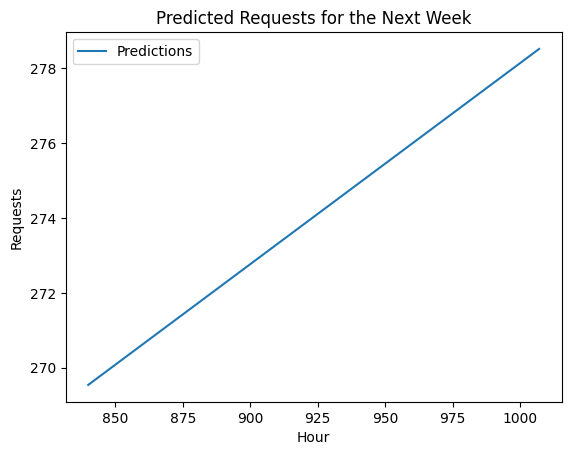

CPU times: user 410 ms, sys: 116 ms, total: 526 ms
Wall time: 601 ms


In [ ]:
%%time
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests[['Requests']])

# Создание признаков и меток
X = requests.index.values.reshape(-1, 1)  # Индекс строки
y = scaled_requests.flatten()

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

# Генерация предсказаний на неделю вперед
future_X = pd.DataFrame(range(len(requests), len(requests) + 168), columns=['Index'])
scaled_predictions = model.predict(future_X)
predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()

# Оценка метрик
mse = mean_squared_error(y, model.predict(X))
print("Mean Squared Error:", mse)

# График предсказаний на неделю вперед (с обратным масштабированием)
plt.plot(future_X, scaler.inverse_transform(scaled_predictions.reshape(-1, 1)), label='Predictions')
plt.xlabel('Hour')
plt.ylabel('Requests')
plt.title('Predicted Requests for the Next Week')
plt.legend()
plt.show()

Для начала мы попробуем построить модель LSTM с нормализацией данных через библиотеку Pytorch. Данная модель поможет выяснить, что лучше для нашей задачи - нормализация данных, или масштабирование.

In [ ]:
%%time
import torch
import torch.nn as nn

# выбор столбца Requests
data = requests.loc[:,["Requests"]].values.astype('float32')

# нормализация данных
mean = np.mean(data)
std = np.std(data)
data = (data - mean) / std

# создание обучающих и тестовых данных
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)
X = torch.from_numpy(X).unsqueeze(2)
y = torch.from_numpy(y)

# определение модели LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')

# проверка на тестовых данных
test_data = data[-int(data.shape[0]*0.2):]
test_inputs = test_data[:seq_length].tolist()
predictions = []
for i in range(len(test_data)-seq_length):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())
        test_inputs.append(test_data[i+seq_length].tolist())

# вывод результатов
predictions = np.array(predictions) * std + mean
print(predictions[:5])

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# прогнозирование на тестовых данных
test_data = data[-int(data.shape[0]*0.2):]
test_inputs = test_data[:seq_length].tolist()
predictions = []
for i in range(len(test_data)-seq_length):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())
        test_inputs.append(test_data[i+seq_length].tolist())

# обратная нормализация данных
predictions = np.array(predictions) * std + mean
test_data = test_data * std + mean

# вычисление метрик
mae = mean_absolute_error(test_data[seq_length:], predictions)
mse = mean_squared_error(test_data[seq_length:], predictions)
r2 = r2_score(test_data[seq_length:], predictions)

# вывод результатов
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")

epoch:   0 loss: 0.13553670
epoch:  10 loss: 0.00385880
epoch:  20 loss: 0.06497923
epoch:  30 loss: 0.02287162
epoch:  40 loss: 0.01770873
epoch:  50 loss: 0.04006790
epoch:  60 loss: 0.00648945
epoch:  70 loss: 0.00192748
epoch:  80 loss: 0.00136130
epoch:  90 loss: 0.00237135
[465.64903016 457.9910022  521.07888761 414.35016934 390.58831024]
MAE: 16.03
MSE: 478.21
R^2: 0.96
CPU times: user 2min 18s, sys: 994 ms, total: 2min 19s
Wall time: 2min 24s


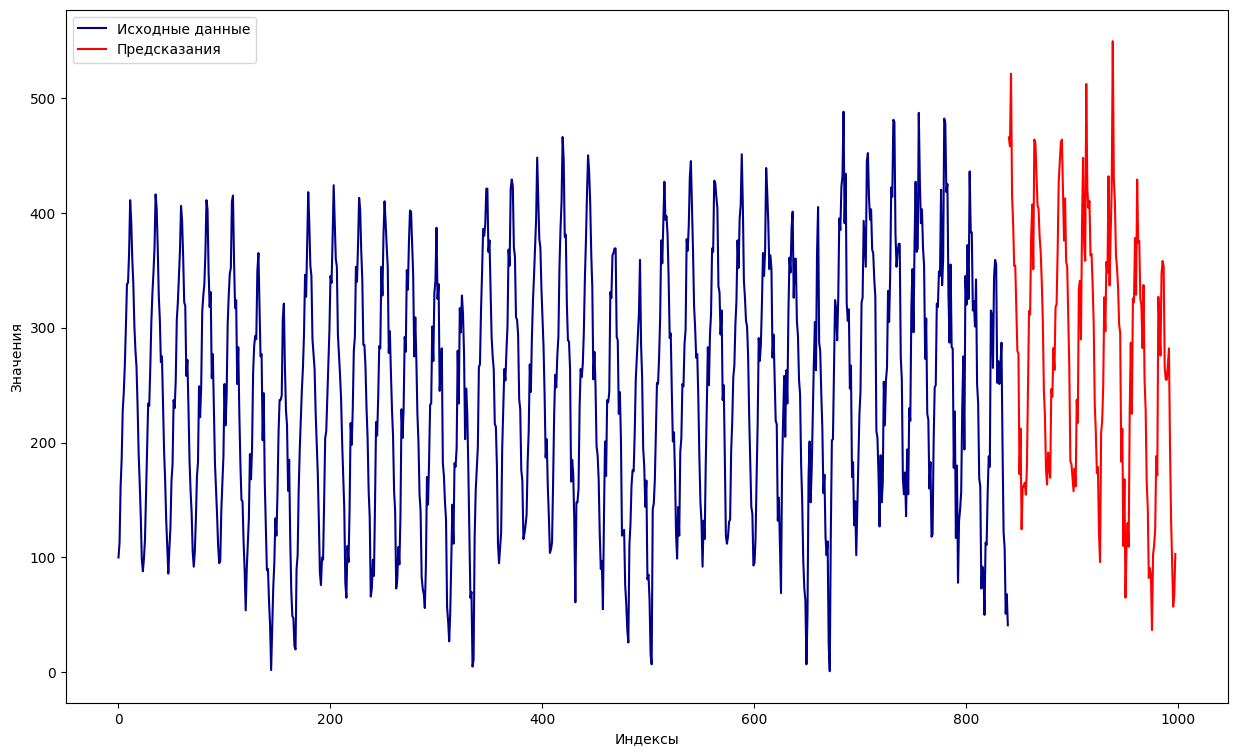

In [ ]:
import matplotlib.pyplot as plt

# построение графика
plt.figure(figsize=(15,9))
plt.plot(requests['Requests'], label='Исходные данные', color="darkblue")
plt.plot(range(requests.shape[0], len(predictions) + requests.shape[0]), predictions, label='Предсказания', color="red")
plt.xlabel('Индексы')
plt.ylabel('Значения')
plt.legend()
plt.show()

И хотя получившиеся данные выглядят правдоподобно, на графике можно наблюдать разрыв между исходными и предсказанными данными. Этот результат заставляет усомниться в данном подходе и вернуться к идеи об использовании масштабированных данных.

In [ ]:
TorchLSTM_future = predictions

Теперь мы построим модель LSTM с помощью Keras для прогнозирования временных рядов. Чтобы предсказать каждую точку данных, нам нужно обеспечить ретроспективный анализ точек данных. Для этого нам нужно создать набор данных, который связывает каждую точку данных с предыдущими 168 точками данных, что соответствует недельному ретроспективному анализу.

Мы делаем это с помощью функции create_rnn_dataset. Эта функция принимает в качестве входных данных набор данных и период ретроспективного анализа. Затем он создает вектор функции X и прогноз Y. X содержит предыдущие 168 точек данных для соответствующего Y. Это означает, что если мы пропустим четыре недели данных, мы получим только три недели X и Y, так как первый неделя будет потеряна в ретроспективе.

Мы перебираем набор данных, создаем X, используя последние 168 точек ретроспективного анализа, а Y — текущую точку. Затем мы возвращаем окончательный массив. Мы используем этот метод для создания массивов X и Y для набора обучающих данных. Затем мы преобразуем X в трехмерный массив для использования с LSTM.

In [ ]:
# создаём функцию для получения векторов X и Y
# каждая точка данных (X) связана с предыдущими точками данных size=lookback.
# прогнозируемое значение (Y) является следующей точкой

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            # lookback точек для конкретной точки
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            # следующая точка
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

# создаём X и Y для тренировки
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

# меняем размерности для использования с LSTM
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Размерности X и Y: ",train_req_x.shape, train_req_y.shape)

Размерности X и Y:  (503, 1, 168) (503,)


Мы видим, что X теперь имеет 503 точки данных, что соответствует данным за три недели, каждая точка данных представляет собой ретроспективу 168 значений.

Теперь приступим к построению модели. Мы создаем последовательную модель в Keras. Затем мы добавляем слой LSTM из 256 единиц. Далее, мы добавляем плотный слой, который выводит одно значение, которое является предсказанным значением узла. Мы компилируем модель с помощью Adam Optimizer, в качестве метрик задаём MSE и MAE. Мы также печатаем сгенерированную модель. Затем мы сопоставляем модель с 5 эпохами и batch_size, равным 1.

In [ ]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

tf.random.set_seed(3)

# создаём модель
ts_model=Sequential()
# добавляем LSTM
ts_model.add(LSTM(128, input_shape=(1,lookback)))
ts_model.add(Dropout(0.0))
ts_model.add(Dense(1))

# компилируем
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse", "mae"])

# выводим информацию о модели
ts_model.summary()

# тренируем модель
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               152064    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 152,193
Trainable params: 152,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 11s 7ms/step - loss: 0.1539 - mse: 0.1539 - mae: 0.3028
Epoch 2/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0708 - mse: 0.0708 - mae: 0.2079
Epoch 3/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0609 - mse: 0.0609 -

Опционально можно использовать GridSearch. Grid search (сеточный поиск) - это метод для определения оптимальных гиперпараметров модели путем перебора различных комбинаций гиперпараметров из заданного набора. Гиперпараметры - это параметры модели, которые не могут быть обучены из данных, а должны быть установлены перед обучением модели.

In [ ]:
%%time
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

tf.random.set_seed(3)

# Функция для создания модели
def create_model(units, dropout_rate, lookback=168):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, lookback)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Создание модели для GridSearchCV
ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)

# Задание гиперпараметров для перебора
param_grid = {
    'units': [128, 256, 512],
    'dropout_rate': [0.0, 0.2, 0.4]
}

# Создание объекта GridSearchCV с параметром error_score='raise'
grid_search = GridSearchCV(estimator=ts_model2, param_grid=param_grid, cv=3, error_score='raise')

# Обучение модели с перебором гиперпараметров
grid_search.fit(train_req_x, train_req_y, epochs=5, batch_size=1)

# Вывод результатов
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


<timed exec>:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best parameters:  {'dropout_rate': 0.0, 'units': 128}
Best score:  -0.09647697458664577
CPU times: user 10min 2s, sys: 23.2 s, total: 10min 25s
Wall time: 10min 24s


Как мы видим, потери быстро уменьшаются примерно до 0.5, a MSE и MAE стремятся к 0.5 и 0.17 соответственно

Мы проверим модель, используя набор тестовых данных. Для прогнозирования каждой точки данных с помощью тестового набора данных у нас есть предыдущие 168 точек данных из фактических данных.

Чтобы протестировать, мы сначала обрабатываем набор тестовых данных с той же функцией create_rnn_dataset, чтобы связать каждую точку данных с предыдущими 168 точками данных. Затем мы используем функцию оценки для оценки модели. Для сравнения мы будем прогнозировать как набор обучающих данных, так и набор тестовых данных. Чтобы просмотреть результаты, нам нужно будет выполнить обратное преобразование, чтобы преобразовать их из стандартной шкалы в ту же шкалу, что и исходные значения.

In [ ]:
from sklearn.metrics import r2_score
# предварительная обработка тестовых данных
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

# оцениваем модель
ts_model.evaluate(test_req_x, test_req_y, verbose=1)

# предсказания для тренировочных данных
predict_on_train= ts_model.predict(train_req_x)
# предсказания для тестовых данных
predict_on_test = ts_model.predict(test_req_x)

r2 = r2_score(train_req_y, predict_on_train)
print("Train R2 Score:", r2)

r2 = r2_score(test_req_y, predict_on_test)
print("Test R2 Score:", r2)

# обратное масштабирование для просмотра результатов
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

6/6 [==============================] - 0s 4ms/step
Train R2 Score: 0.9542722422677061
Test R2 Score: 0.8481994567365114


Теперь мы построим полученные прогнозы, чтобы увидеть, как они совпадают с исходными данными. Общий размер графика будет представлять собой объединенный размер прогнозов обучения и тестирования. Сначала мы получаем исходные данные из фрейма данных и преобразовываем их в ту же форму, что и у прогнозов. Затем мы создаем исходный график размером, равным общему количеству прогнозов. Копируем в этот блок значение начиная с 168 точки в исходных данных. Это связано с тем, что для первых 167 точек нет прогнозов, поскольку они используются только в качестве ретроспективных.

Затем мы создаем обучающий график аналогичным образом, но копируем данные только для того, чтобы они соответствовали тем же равным и исходным точкам данных, то есть второй, третьей и четвертой неделям.

Затем мы создаем тестовый график, сопоставляя графики с одинаковыми конечными точками и оригиналом, то есть только пятой неделей. Давайте выполним этот код и просмотрим объединенные результаты. На этом графике мы видим синюю линию, которая является исходными данными. Оранжевая линия предназначена для прогнозов набора обучающих данных на вторую, третью и четвертую недели. Красная линия — это прогноз на пятую неделю, которая находится в наборе тестовых данных. Как мы видим, прогнозы точно соответствуют тенденциям, наблюдаемым в исходных данных. Это достаточно хороший прогноз.

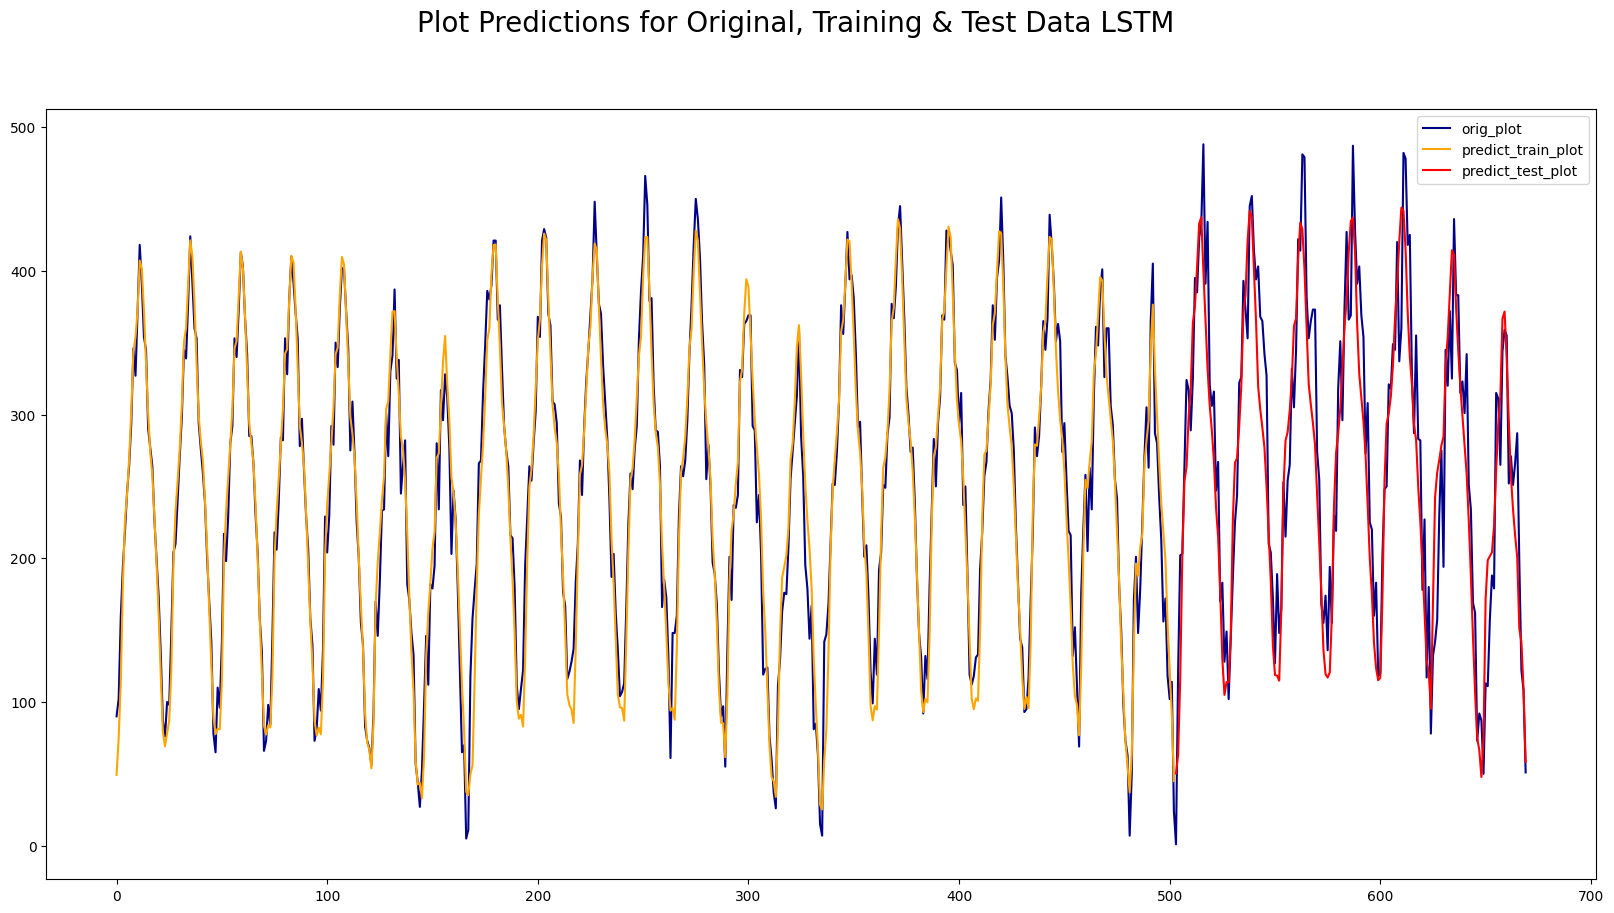

In [ ]:
# общий размер графика
total_size = len(predict_on_train) + len(predict_on_test)

# исходные данные
orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

# создаём переменную с исходными данными
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

# создаём переменную с предсказаниями на тренировачных данных
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

# создаём переменную с предсказаниями на тестовых данных
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

# строим график
plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data LSTM", fontsize=20)
plt.plot(orig_plot, label='orig_plot', color='darkblue')
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.legend()
plt.show()

Мы будем прогнозировать будущие нагрузки на сервисы на целую неделю, используя построенную нами модель. Здесь важно учитывать один важный фактор. В случае с тестовыми данными, которые мы использовали, для каждой точки данных, которую мы хотели предсказать, у нас было 168 ретроспективных точек данных из фактических данных.

Но если мы хотим предсказать в будущем, мы можем предсказать только первую точку, так как только эта точка имеет полный ретроспективный взгляд на фактические данные. Если мы уменьшим размер нашего ретроспективного анализа, это повлияет на общую точность наших прогнозов.

**Таким образом, размер ретроспективного анализа напрямую влияет на точность предсказаний. Данный факт следует учитывать в случае, когда мы хотим улучшить точность наших прогнозов**

Для предсказания мы итеративно прогнозируем каждую точку данных, а затем добавляем эту прогнозируемую точку в набор ретроспективных данных для следующей точки. Например, чтобы предсказать новую точку прогноза P1, мы используем последние 168 точек из тестового набора данных. Затем, чтобы предсказать следующую точку, то есть P2, мы используем ретроспективный анализ, который содержит P1 и последние 167 точек из тестового набора данных. В этом итеративном процессе мы используем предсказанные значения в ретроспективном поиске следующего значения.

Сначала мы используем тестовый набор данных, который у нас есть, и сглаживаем его. Мы сохраняем это как текущую книгу, которая будет входным набором данных. Затем мы устанавливаем прогноз для переменной на следующие 168 пунктов, то есть на неделю вперед. Затем мы повторяем предсказание несколько раз. Мы прогнозируем первую точку данных, используя тестовые данные в качестве входных данных. Мы берем предсказанное значение, а затем добавляем его к текущей входной переменной.

В следующей итерации мы используем последние 168 точек данных, включая первое предсказанное значение. Таким образом, мы прогнозируем каждую точку данных и используем ее в качестве входных данных для следующей точки данных. Продолжая этот процесс, мы делаем прогноз на всю неделю. Затем мы копируем предсказанные значения и выполняем обратное преобразование, чтобы преобразовать их в фактический масштаб. Давайте рассмотрим первые пять прогнозируемых точек данных.

In [ ]:
# используем последнюю часть обучающих данных в качестве начального ретроспективного взгляда
curr_input= test_req_x[-1,:].flatten()

# прогноз на следующую неделю
predict_for = 24 * 7

for i in range(predict_for):
    
    this_input=curr_input[-lookback:]
    this_input=this_input.reshape((1,1,lookback))
    # предсказываем следующую точку
    this_prediction=ts_model.predict(this_input)

    # добавляем текущий прогноз на вход
    curr_input = np.append(curr_input,this_prediction.flatten())

# извлекаем последнюю предиктивную часть curr_input, содержащую все новые прогнозы
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# инверсируем для просмотра результатов
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

1/1 [==============================] - 0s 22ms/step
[[ 58.2860596 ]
 [ 53.2473044 ]
 [ 67.52460811]
 [ 82.33804335]
 [139.48940218]]


Далее, мы нанесем это значение на график, чтобы увидеть, видим ли мы такие же тенденции. Подобно тому, как мы делали это раньше, мы создаем диаграмму, показывающую тренировочные недели, т.е. вторую, третью и четвертую, тестовую неделю, т.е. пятую, и будущую неделю, т.е. шестую.

Прогнозы на тренировочные недели показаны синим цветом, тестовая неделя — оранжевым, а будущая неделя — зеленым. Как мы видим, прогноз на будущую неделю в значительной степени следует циклическим моделям для дней, а также сезонным моделям для недели. Это также сохраняет тенденцию роста.

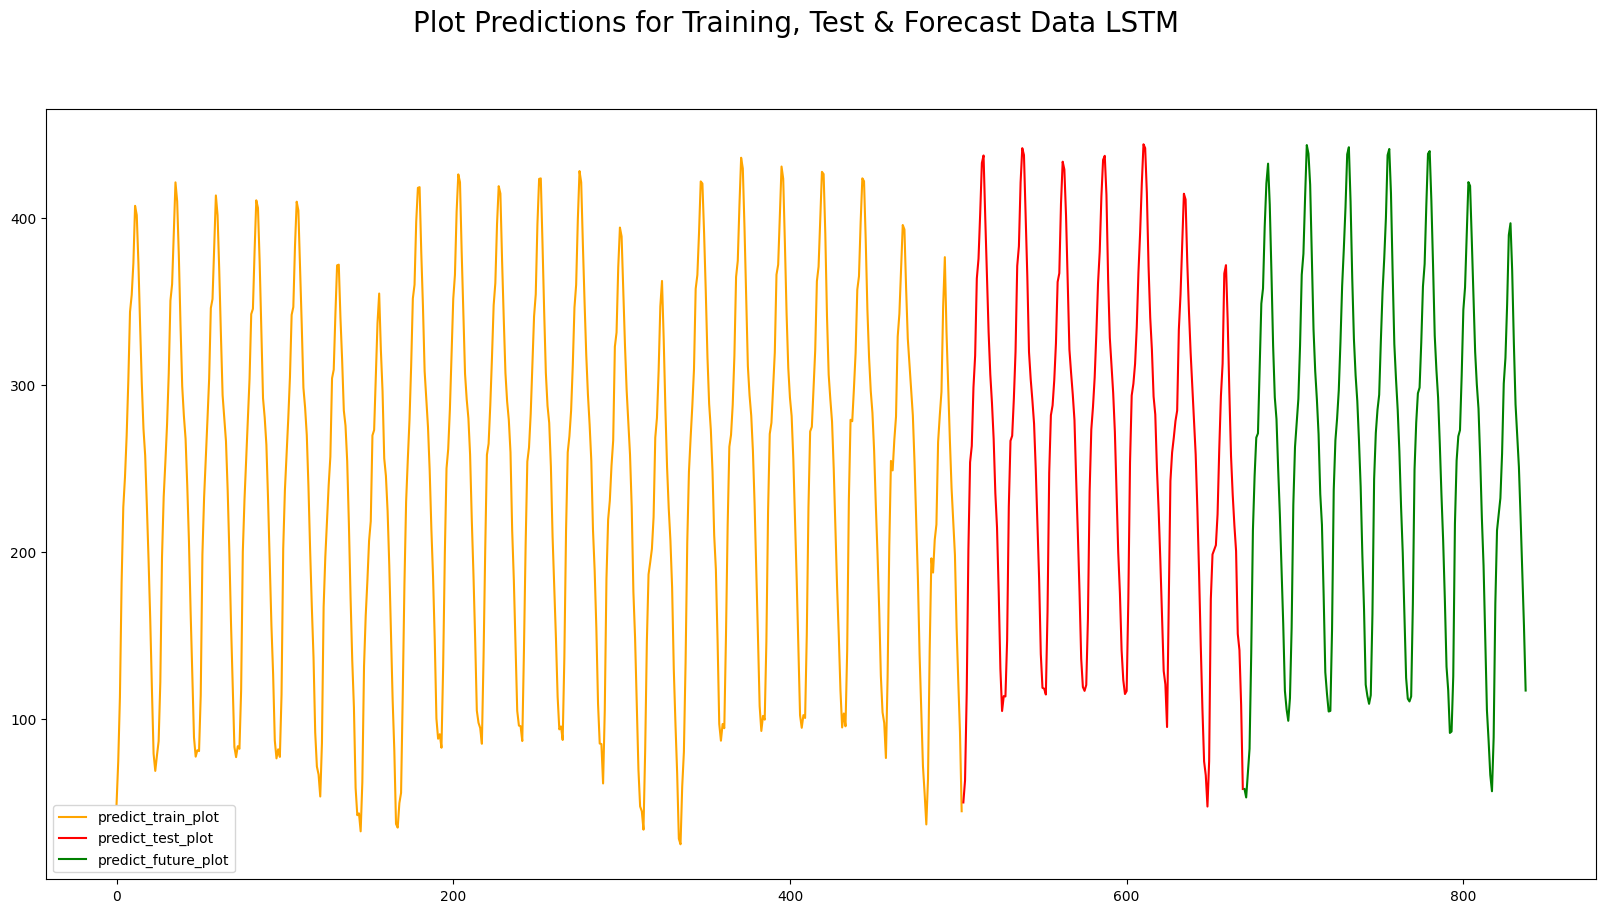

In [ ]:
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data LSTM", fontsize=20)
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.plot(predict_future_plot, label='predict_future_plot', color='green')
plt.legend()
plt.show()

In [ ]:
LSTM_future = predict_future_plot

Далее следует обрабтиться к различным типам рекуррентных слоев в нейронных сетях (GRU и SimpleRNN). Эти слои предназначены для обработки последовательностей и имеют различные свойства и возможности.

* GRU (Gated Recurrent Unit) - это модификация LSTM, которая упрощает архитектуру, объединяя в себе "забывающий" и "входной" шлюзы LSTM в один "обновляющий" шлюз, и заменяя "выходной" шлюз на единичный вектор. GRU имеет меньше параметров, чем LSTM, и зачастую более быстро обучается.

* SimpleRNN (Simple Recurrent Neural Network) - это самый простой тип рекуррентных слоев, который представляет собой полносвязную сеть с обратной связью. SimpleRNN не имеет механизма ячейки памяти и не может эффективно обрабатывать длинные зависимости в данных.

In [ ]:
%%time
from tensorflow.keras.layers import GRU

tf.random.set_seed(3)

# создаём модель
ts_model=Sequential()

# добавляем GRU
ts_model.add(GRU(512, input_shape=(1,lookback)))
ts_model.add(Dropout(0.4))
ts_model.add(Dense(1))

# компилируем
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse", "mae"])

# выводим информацию о модели
ts_model.summary()

# тренируем модель
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_29 (GRU)                (None, 512)               1047552   
                                                                 
 dropout_57 (Dropout)        (None, 512)               0         
                                                                 
 dense_59 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,048,065
Trainable params: 1,048,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 8s 13ms/step - loss: 0.4869 - mse: 0.4869 - mae: 0.5459
Epoch 2/5
503/503 [==============================] - 6s 13ms/step - loss: 0.1970 - mse: 0.1970 - mae: 0.3481
Epoch 3/5
503/503 [==============================] - 6s 13ms/step - loss: 0.1375 - mse: 0

In [ ]:
%%time
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

tf.random.set_seed(3)

# Функция для создания модели
def create_model(units, dropout_rate, lookback=168):
    model = Sequential()
    model.add(GRU(units, input_shape=(1, lookback)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Создание модели для GridSearchCV
ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)

# Задание гиперпараметров для перебора
param_grid = {
    'units': [128, 256, 512],
    'dropout_rate': [0.0, 0.2, 0.4]
}

# Создание объекта GridSearchCV с параметром error_score='raise'
grid_search = GridSearchCV(estimator=ts_model2, param_grid=param_grid, cv=3, error_score='raise')

# Обучение модели с перебором гиперпараметров
grid_search.fit(train_req_x, train_req_y, epochs=5, batch_size=1)

# Вывод результатов
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


<timed exec>:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best parameters:  {'dropout_rate': 0.4, 'units': 512}
Best score:  -0.0957209939757983
CPU times: user 8min 56s, sys: 17 s, total: 9min 13s
Wall time: 7min 42s


In [ ]:
# предварительная обработка тестовых данных
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

ts_model.evaluate(test_req_x, test_req_y, verbose=1)

# предсказания для тренировочных данных
predict_on_train = ts_model.predict(train_req_x)
# предсказания для тестовых данных
predict_on_test = ts_model.predict(test_req_x)

r2 = r2_score(train_req_y, predict_on_train)
print("Train R2 Score:", r2)

r2 = r2_score(test_req_y, predict_on_test)
print("Test R2 Score:", r2)

# обратное масштабирование для просмотра результатов
predict_on_train = scaler.inverse_transform(predict_on_train.reshape(-1,1)).reshape(-1)
predict_on_test = scaler.inverse_transform(predict_on_test.reshape(-1,1)).reshape(-1)

6/6 [==============================] - 0s 7ms/step
Train R2 Score: 0.9009031383749325
Test R2 Score: 0.7577837900862583


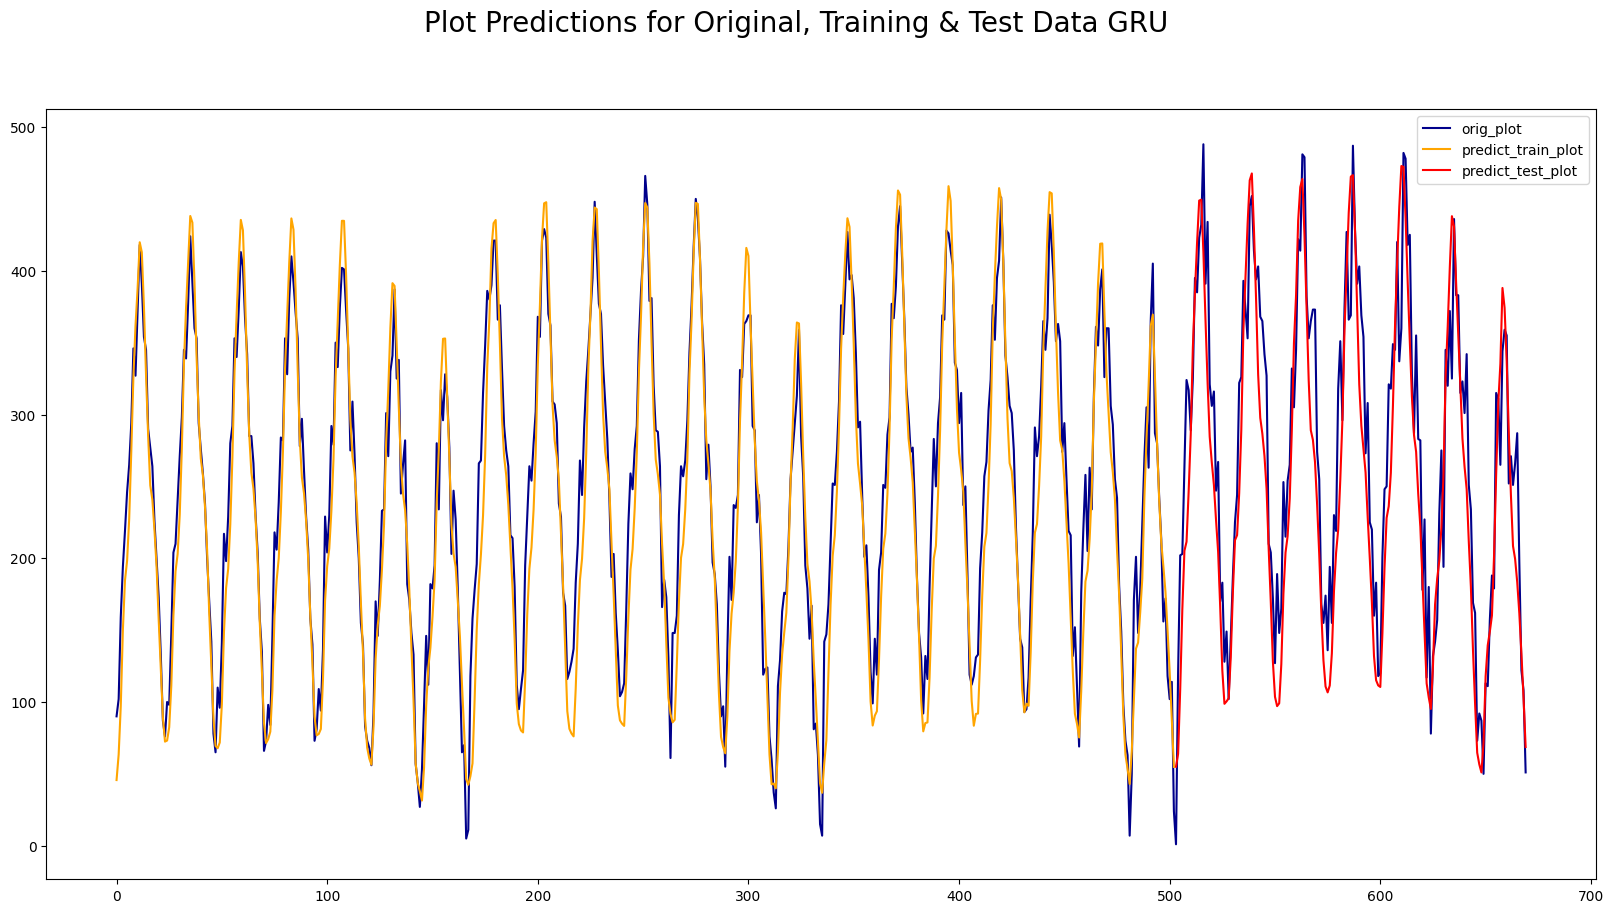

In [ ]:
total_size = len(predict_on_train) + len(predict_on_test)

orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train.reshape(-1,1)

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test.reshape(-1,1)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data GRU", fontsize=20)
plt.plot(orig_plot, label='orig_plot', color='darkblue')
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.legend()
plt.show()

In [ ]:
# используем последнюю часть обучающих данных в качестве начального ретроспективного взгляда
curr_input= test_req_x[-1,:].flatten()

# прогноз на следующую неделю
predict_for = 24 * 7

for i in range(predict_for):
    
    this_input=curr_input[-lookback:]
    this_input=this_input.reshape((1,1,lookback))
    # предсказываем следующую точку
    this_prediction=ts_model.predict(this_input)

    # добавляем текущий прогноз на вход
    curr_input = np.append(curr_input,this_prediction.flatten())

# извлекаем последнюю предиктивную часть curr_input, содержащую все новые прогнозы
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# инверсируем для просмотра результатов
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

1/1 [==============================] - 0s 23ms/step
[[ 68.65169302]
 [ 63.83896878]
 [ 73.50576486]
 [ 91.23209277]
 [123.17528934]]


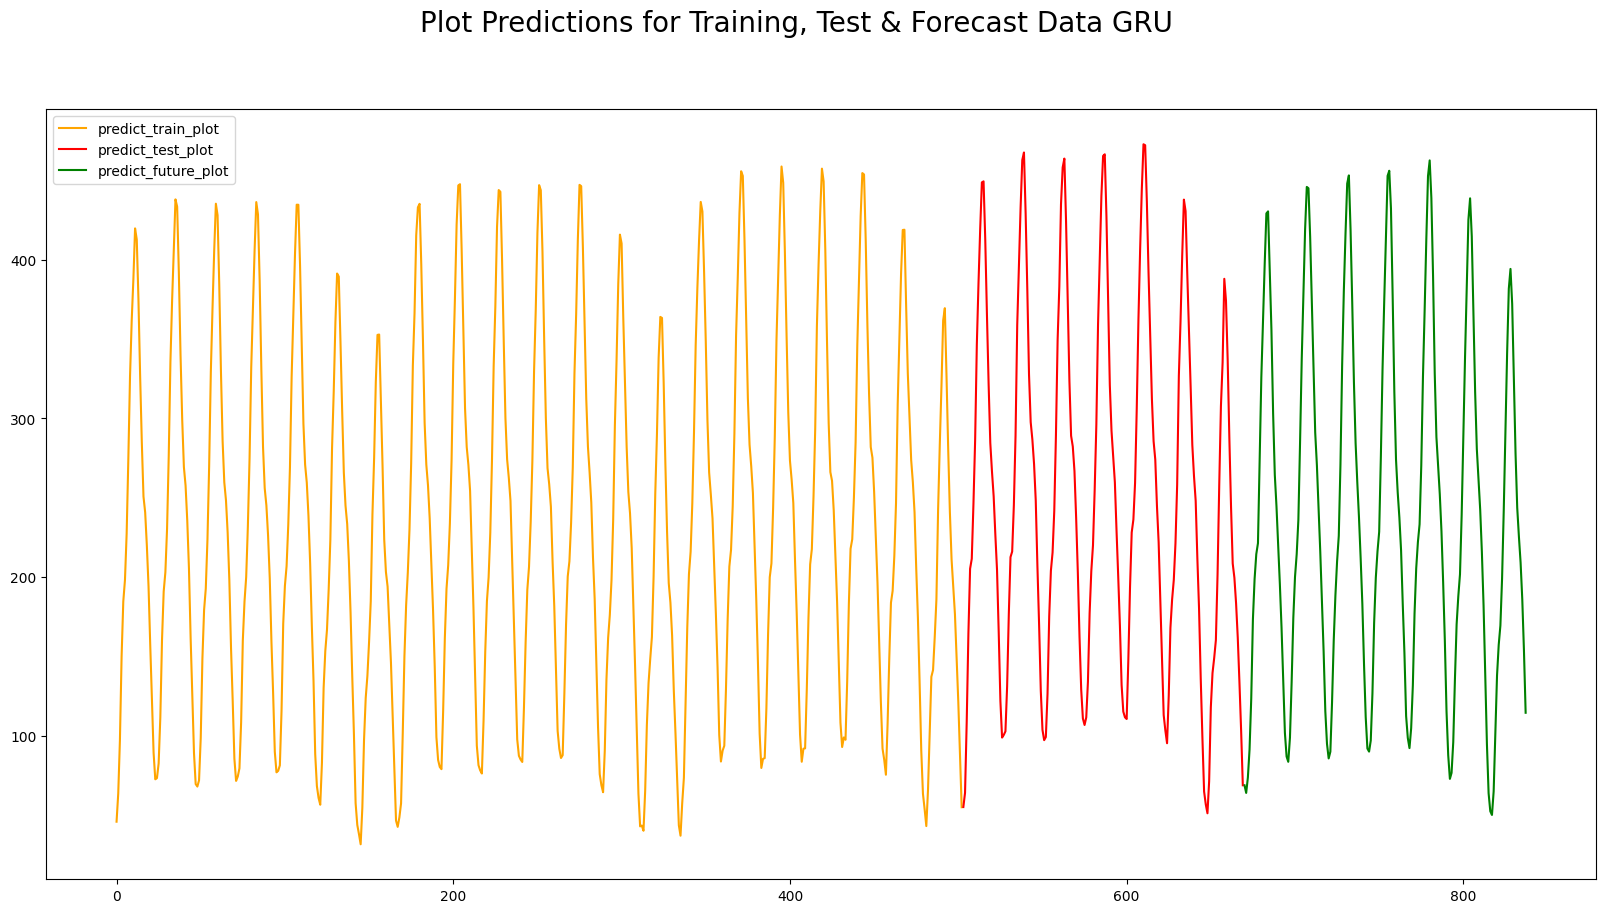

In [ ]:
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train.reshape(-1,1)

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test.reshape(-1,1)

predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data GRU", fontsize=20)
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.plot(predict_future_plot, label='predict_future_plot', color='green')
plt.legend()
plt.show()

In [ ]:
GRU_future = predict_future_plot

In [ ]:
%%time
from tensorflow.keras.layers import SimpleRNN
tf.random.set_seed(3)

# создаём модель
ts_model = Sequential()

# добавляем SimpleRNN
ts_model.add(SimpleRNN(128, input_shape=(1, lookback)))
ts_model.add(Dropout(0.4))
# добавляем выходной слой
ts_model.add(Dense(1))

# компилируем
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse", "mae"])

# выводим информацию о модели
ts_model.summary()

# тренируем модель
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)


Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_29 (SimpleRNN)   (None, 128)               38016     
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 dense_89 (Dense)            (None, 1)                 129       
                                                                 
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 2s 2ms/step - loss: 0.8048 - mse: 0.8048 - mae: 0.7089
Epoch 2/5
503/503 [==============================] - 1s 2ms/step - loss: 0.4284 - mse: 0.4284 - mae: 0.5205
Epoch 3/5
503/503 [==============================] - 1s 2ms/step - loss: 0.2373 - mse: 0.2373 - m

In [ ]:
%%time
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

tf.random.set_seed(3)

# Функция для создания модели
def create_model(units, dropout_rate, lookback=168):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(1, lookback)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Создание модели для GridSearchCV
ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)

# Задание гиперпараметров для перебора
param_grid = {
    'units': [128, 256, 512],
    'dropout_rate': [0.0, 0.2, 0.4]
}

# Создание объекта GridSearchCV с параметром error_score='raise'
grid_search = GridSearchCV(estimator=ts_model2, param_grid=param_grid, cv=3, error_score='raise')

# Обучение модели с перебором гиперпараметров
grid_search.fit(train_req_x, train_req_y, epochs=5, batch_size=1)

# Вывод результатов
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


<timed exec>:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best parameters:  {'dropout_rate': 0.4, 'units': 128}
Best score:  -0.11568899701038997
CPU times: user 3min 33s, sys: 7.59 s, total: 3min 40s
Wall time: 3min 45s


In [ ]:
test_req_x, test_req_y = create_rnn_dataset(test_requests, lookback)
test_req_x = np.reshape(test_req_x, (test_req_x.shape[0], 1, test_req_x.shape[1]))

ts_model.evaluate(test_req_x, test_req_y, verbose=1)

predict_on_train = ts_model.predict(train_req_x)
predict_on_test = ts_model.predict(test_req_x)

r2 = r2_score(train_req_y, predict_on_train)
print("Train R2 Score:", r2)

r2 = r2_score(test_req_y, predict_on_test)
print("Test R2 Score:", r2)

predict_on_train = scaler.inverse_transform(predict_on_train.reshape(-1, 1)).reshape(-1)
predict_on_test = scaler.inverse_transform(predict_on_test.reshape(-1, 1)).reshape(-1)


6/6 [==============================] - 0s 2ms/step
Train R2 Score: 0.9384018274023281
Test R2 Score: 0.8249707128368208


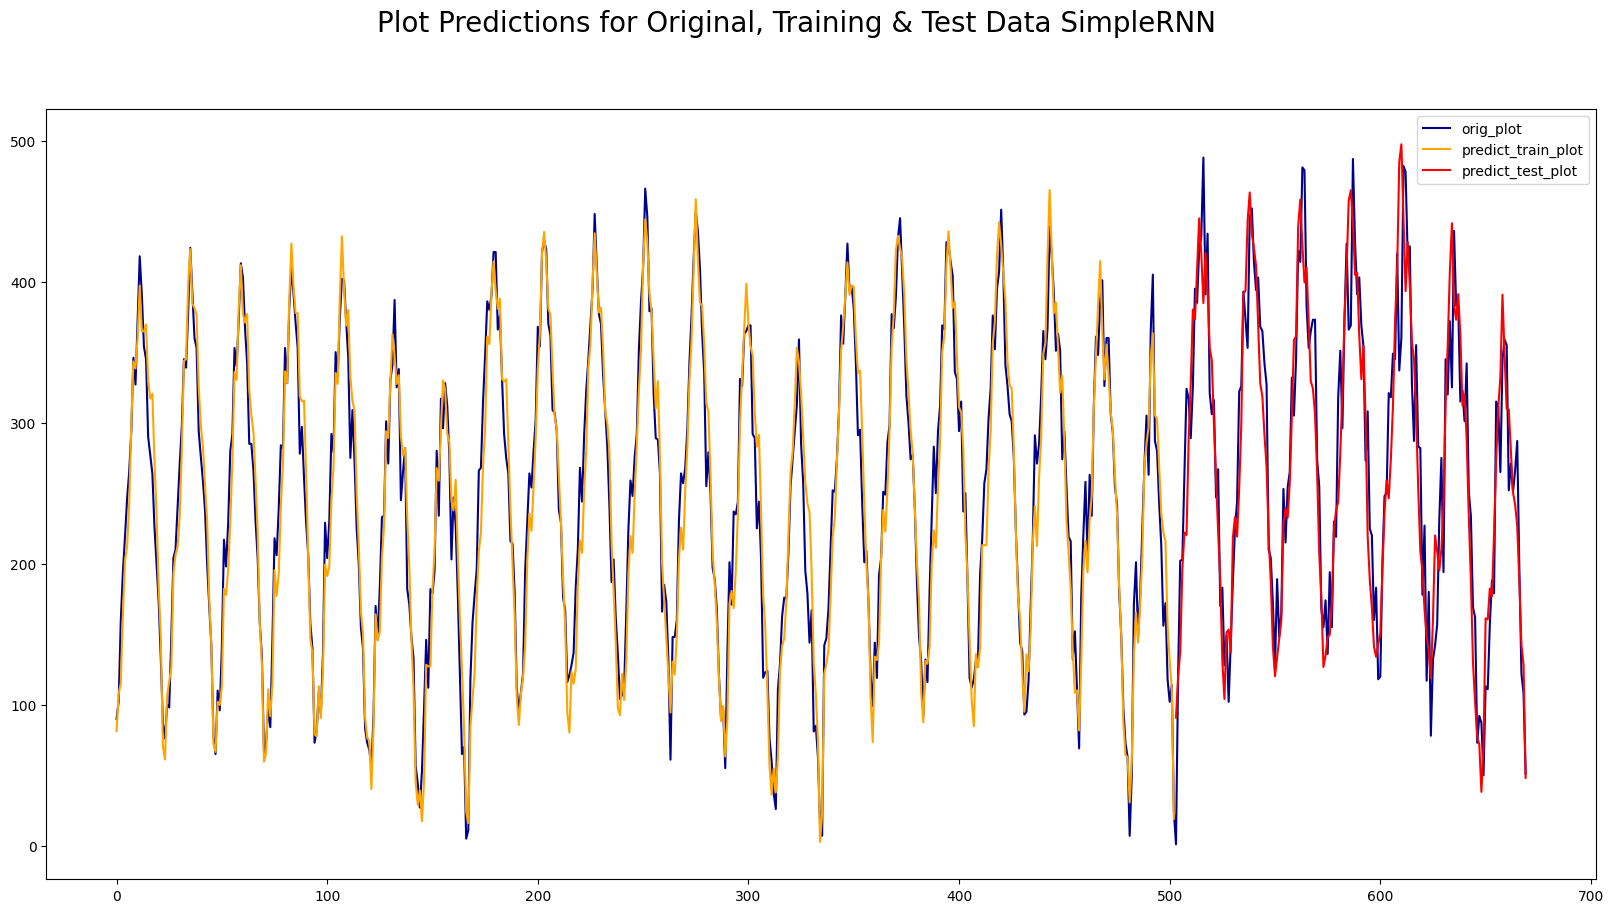

In [ ]:
total_size = len(predict_on_train) + len(predict_on_test)

orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train.reshape(-1,1)

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test.reshape(-1,1)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data SimpleRNN", fontsize=20)
plt.plot(orig_plot, label='orig_plot', color='darkblue')
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.legend()
plt.show()

In [ ]:
curr_input= test_req_x[-1,:].flatten()

predict_for = 24 * 7

for i in range(predict_for):
    
    this_input=curr_input[-lookback:]
    this_input=this_input.reshape((1,1,lookback))
    this_prediction=ts_model.predict(this_input)

    curr_input = np.append(curr_input,this_prediction.flatten())

predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

1/1 [==============================] - 0s 21ms/step
[[104.29715016]
 [104.60870219]
 [106.41686001]
 [138.83508512]
 [161.16773324]]


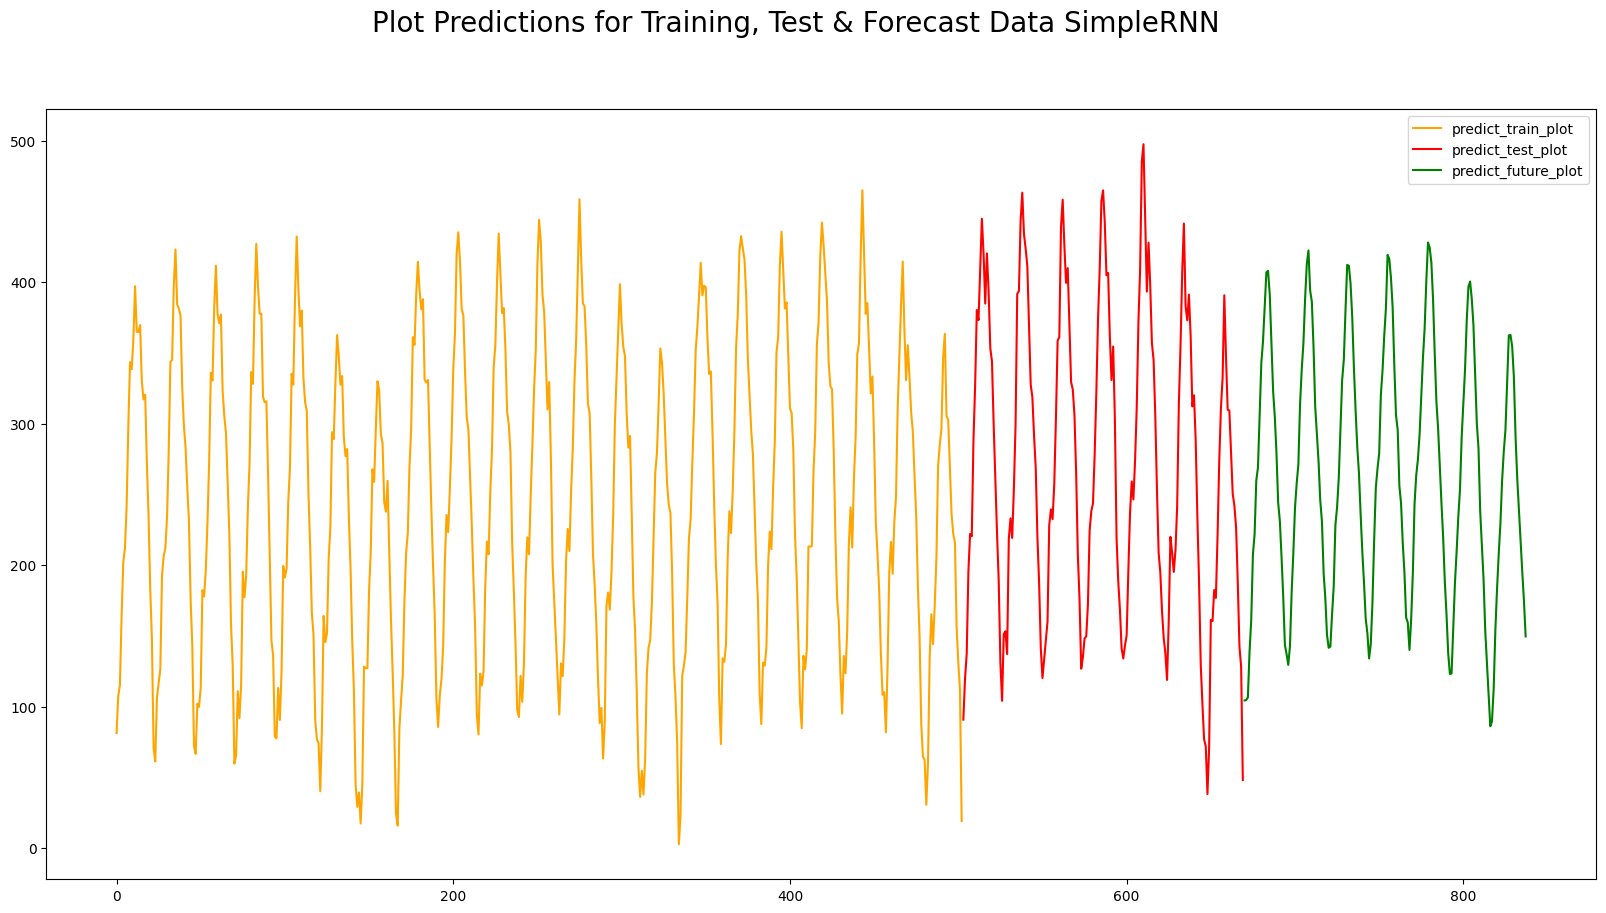

In [ ]:
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train.reshape(-1,1)

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test.reshape(-1,1)

predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data SimpleRNN", fontsize=20)
plt.plot(predict_train_plot, label='predict_train_plot', color='orange')
plt.plot(predict_test_plot, label='predict_test_plot', color='red')
plt.plot(predict_future_plot, label='predict_future_plot', color='green')
plt.legend()
plt.show()

In [ ]:
SimpleRNN_future = predict_future_plot

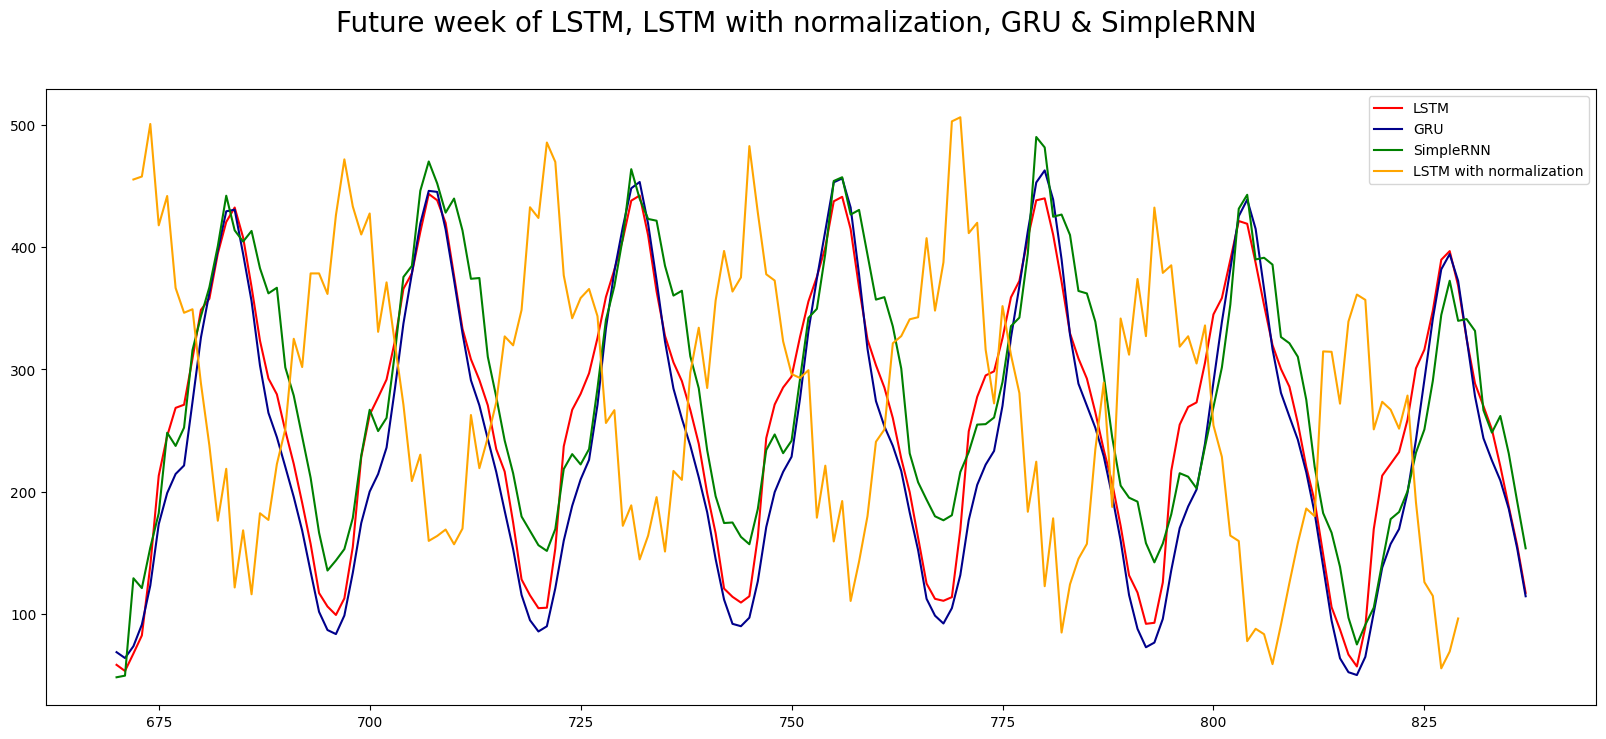

In [ ]:
plt.figure(figsize=(20,8)).suptitle("Future week of LSTM, LSTM with normalization, GRU & SimpleRNN", fontsize=20)
plt.plot(LSTM_future, label='LSTM', color='red')
plt.plot(GRU_future, label='GRU', color='darkblue')
plt.plot(SimpleRNN_future, label='SimpleRNN', color='green')
plt.plot(range(672, 672 + len(TorchLSTM_future)),TorchLSTM_future, label='LSTM with normalization', color='orange')
plt.legend()
plt.show()

Мы получили, что модель GRU обеспечивает лучшую производительность по сравнению с моделями LSTM и SimpleRNN.

Хотя модель LSTM тоже показывает неплохие результаты по метрикам MSE и MAE, она более медленная, чем модель GRU, что делает её менее оптимальной для нашей задачи, где требуется высокая скорость обработки данных.

С другой стороны, модель SimpleRNN значительно быстрее обработки данных, но её производительность значительно хуже, чем у моделей GRU и LSTM. Она не способна уловить долгосрочные зависимости в данных, что приводит к плохой производительности нашей модели.

Таким образом, наша модель GRU сочетает в себе преимущества моделей LSTM и SimpleRNN. Она быстрее LSTM и имеет почти такую же высокую точность. Она также более точная, чем SimpleRNN, и может улавливать долгосрочные зависимости в данных. Таким образом, модель GRU является наилучшим выбором для нашей задачи прогнозирования временных рядов.


In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

def one_week_predict(path):
  requests = pd.read_csv(path, header=0)

  scaler = StandardScaler()
  scaled_requests=scaler.fit_transform(requests)

  # данные обучения должны быть последовательными - берём первые 4 недели
  train_size = 24 * 7 * 4

  # количество предидущих точек данных для каждой конкретной - берём 168, т.е. неделя
  lookback=24 * 7

  # разделяем на тренировочные и тестовые данные
  train_requests = scaled_requests[0:train_size,:]

  # добавляем неделю для нашего lookback
  test_requests = scaled_requests[train_size-lookback:,:]

  # Функция для создания модели
  def create_model(units, dropout_rate, lookback=168):
      model = Sequential()
      model.add(GRU(units, input_shape=(1, lookback)))
      model.add(Dropout(dropout_rate))
      model.add(Dense(1))
      model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
      return model

  # Создание модели для GridSearchCV
  ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)

  # Задание гиперпараметров для перебора
  param_grid = {
      'units': [128, 256, 512],
      'dropout_rate': [0.0, 0.2, 0.4]
  }

  # Создание объекта GridSearchCV с параметром error_score='raise'
  grid_search = GridSearchCV(estimator=ts_model2, param_grid=param_grid, cv=3, error_score='raise')

  # Обучение модели с перебором гиперпараметров
  grid_search.fit(train_req_x, train_req_y, epochs=5, batch_size=1)

  # создаём модель
  ts_model=Sequential()
  # добавляем LSTM
  ts_model.add(GRU(grid_search.best_params_['units'], input_shape=(1,lookback)))
  ts_model.add(Dropout(grid_search.best_params_['dropout_rate']))
  ts_model.add(Dense(1))

  # компилируем
  ts_model.compile(loss="mean_squared_error",
                  optimizer="adam",
                  metrics=["mse", "mae"])

  # выводим информацию о модели
  ts_model.summary()

  # тренируем модель
  ts_model.fit(train_req_x, train_req_y, 
              epochs=5, batch_size=1, verbose=1)
  
  test_req_x, test_req_y = create_rnn_dataset(test_requests, lookback)
  test_req_x = np.reshape(test_req_x, (test_req_x.shape[0], 1, test_req_x.shape[1]))

  ts_model.evaluate(test_req_x, test_req_y, verbose=1)

  predict_on_train = ts_model.predict(train_req_x)
  predict_on_test = ts_model.predict(test_req_x)

  r2 = r2_score(train_req_y, predict_on_train)
  print("Train R2 Score:", r2)

  r2 = r2_score(test_req_y, predict_on_test)
  print("Test R2 Score:", r2)

  predict_on_train = scaler.inverse_transform(predict_on_train.reshape(-1, 1)).reshape(-1)
  predict_on_test = scaler.inverse_transform(predict_on_test.reshape(-1, 1)).reshape(-1)

  curr_input= test_req_x[-1,:].flatten()

  predict_for = 24 * 7

  for i in range(predict_for):
      
      this_input=curr_input[-lookback:]
      this_input=this_input.reshape((1,1,lookback))
      this_prediction=ts_model.predict(this_input)

      curr_input = np.append(curr_input,this_prediction.flatten())

  predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

  predict_on_future=scaler.inverse_transform(predict_on_future)

  total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

  predict_future_plot = np.empty((total_size,1))
  predict_future_plot[:, :] = np.nan
  predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

  plt.plot(predict_future_plot, label='predict_future_plot', color='red')
  plt.legend()
  plt.show()

  return ts_model

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

def one_week_predict(path):
  requests = pd.read_csv(path, header=0)

  # масштабируем данные
  print("Диапозон данных до масштабирования : " , 
          min(requests.Requests),
          max(requests.Requests))

  scaler = StandardScaler()
  scaled_requests=scaler.fit_transform(requests)
  print("Диапозон данных после масштабирования : " , 
          min(scaled_requests),
          max(scaled_requests))

  # данные обучения должны быть последовательными - берём первые 4 недели
  train_size = 24 * 7 * 4

  # количество предидущих точек данных для каждой конкретной - берём 168, т.е. неделя
  lookback=24 * 7

  # разделяем на тренировочные и тестовые данные
  train_requests = scaled_requests[0:train_size,:]

  # добавляем неделю для нашего lookback
  test_requests = scaled_requests[train_size-lookback:,:]

  print("\nРазмерности тренировочных и тестовых данных: ",
      train_requests.shape, test_requests.shape)
  print(f"\nКоличество недель обучающих данных: {int(train_requests.shape[0]/(requests.shape[0]/int(requests.shape[0]/24/7)))}")
  print(f"Количество недель тестовых данных: {int(test_requests.shape[0]/(requests.shape[0]/int(requests.shape[0]/24/7)))}")

  def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            # lookback точек для конкретной точки
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            # следующая точка
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

    # создаём X и Y для тренировки
    train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

    # меняем размерности для использования с LSTM
    train_req_x = np.reshape(train_req_x, 
                            (train_req_x.shape[0],1, train_req_x.shape[1]))

    print("Размерности X и Y: ",train_req_x.shape, train_req_y.shape)

    tf.random.set_seed(3)

    # Функция для создания модели
    def create_model(units, dropout_rate, lookback=168):
        model = Sequential()
        model.add(GRU(units, input_shape=(1, lookback)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
        return model

    # Создание модели для GridSearchCV
    ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)

    # Задание гиперпараметров для перебора
    param_grid = {
        'units': [128, 256, 512],
        'dropout_rate': [0.0, 0.2, 0.4]
    }

    # Создание объекта GridSearchCV с параметром error_score='raise'
    grid_search = GridSearchCV(estimator=ts_model2, param_grid=param_grid, cv=3, error_score='raise')

    # Обучение модели с перебором гиперпараметров
    grid_search.fit(train_req_x, train_req_y, epochs=5, batch_size=1)

    # Вывод результатов
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    tf.random.set_seed(3)

    # создаём модель
    ts_model=Sequential()

    # добавляем GRU
    ts_model.add(GRU(grid_search.best_params_['units'], input_shape=(1,lookback)))
    ts_model.add(Dropout(grid_search.best_params_['dropout_rate']))
    ts_model.add(Dense(1))

    # компилируем
    ts_model.compile(loss="mean_squared_error",
                    optimizer="adam",
                    metrics=["mse", "mae"])

    # выводим информацию о модели
    ts_model.summary()

    # тренируем модель
    ts_model.fit(train_req_x, train_req_y, 
                epochs=5, batch_size=1, verbose=1)
    
    # предварительная обработка тестовых данных
    test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
    test_req_x = np.reshape(test_req_x, 
                            (test_req_x.shape[0],1, test_req_x.shape[1]))

    ts_model.evaluate(test_req_x, test_req_y, verbose=1)

    # предсказания для тренировочных данных
    predict_on_train = ts_model.predict(train_req_x)
    # предсказания для тестовых данных
    predict_on_test = ts_model.predict(test_req_x)

    r2 = r2_score(train_req_y, predict_on_train)
    print("Train R2 Score:", r2)

    r2 = r2_score(test_req_y, predict_on_test)
    print("Test R2 Score:", r2)

    # обратное масштабирование для просмотра результатов
    predict_on_train = scaler.inverse_transform(predict_on_train.reshape(-1,1)).reshape(-1)
    predict_on_test = scaler.inverse_transform(predict_on_test.reshape(-1,1)).reshape(-1)

    total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

    predict_future_plot = np.empty((total_size,1))
    predict_future_plot[:, :] = np.nan
    predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

    GRU_future = predict_future_plot

    plt.plot(GRU_future, label='GRU predict', color='red')
    plt.legend()
    plt.show()

  return ts_model

<ipython-input-35-ee8f0507ae8c>:36: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ts_model2 = KerasRegressor(build_fn=create_model, verbose=0)


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 256)               327168    
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 327,425
Trainable params: 327,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 6s 7ms/step - loss: 0.4102 - mse: 0.4102 - mae: 0.5101
Epoch 2/5
503/503 [==============================] - 4s 9ms/step - loss: 0.2218 - mse: 0.2218 - mae: 0.3704
Epoch 3/5
503/503 [==============================] - 4s 8ms/step - loss: 0.1198 - mse: 0.1198 -

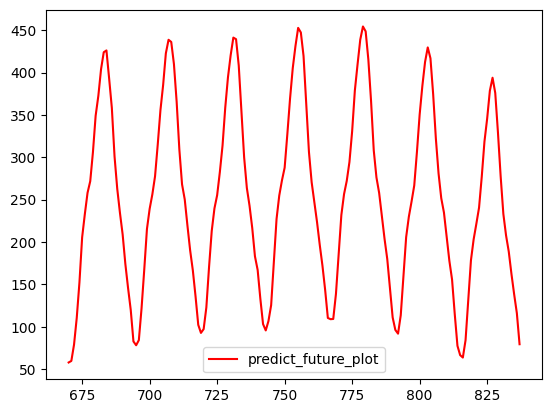

CPU times: user 10min 28s, sys: 19.7 s, total: 10min 48s
Wall time: 11min 16s


In [ ]:
%%time
my_model = one_week_predict('data/requests_every_hour.csv')